In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading and Preprocessing the Data

In [2]:
# Setting Paths
data_images = "/Users/mallikagupta/Desktop/Spring 2024 Courses/STAT 4744/Final Project/Images"
data_captions = "/Users/mallikagupta/Desktop/Spring 2024 Courses/STAT 4744/Final Project/captions.txt"
data_descriptions = "/Users/mallikagupta/Desktop/Spring 2024 Courses/STAT 4744/Final Project/descriptions.txt"

In [3]:
import string

# get all imgs with their captions
def all_img_captions(filename):
    try:
        with open(filename, 'r') as file:
            captions = file.read().strip().split('\n')
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return None
    except Exception as e:
        print(f"Error: {e}")
        return None
    
    descriptions = {}
    table = str.maketrans('', '', string.punctuation)

    for caption in captions:
        img, caption_text = caption.split('\t')
        img = img[:-2]  # Removing the #0, #1, ... from the image name
        caption_text = caption_text.replace("-", " ")  # Remove hyphens
        words = caption_text.split()
        words = [word.lower().translate(table) for word in words if word.isalpha() and len(word) > 1]
        cleaned_caption = ' '.join(words)
        
        if img not in descriptions:
            descriptions[img] = [cleaned_caption]
        else:
            descriptions[img].append(cleaned_caption)
            
    return descriptions

def text_vocabulary(descriptions):
    vocab = set()

    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]

    return vocab

# All descriptions in one file
def save_descriptions(descriptions, filename):
    lines = []
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc)
    data = "\n".join(lines)
    with open(filename, "w") as file:
        file.write(data)

# Set these paths according to the project folder in your system
data_text = "/Users/mallikagupta/Desktop/Spring 2024 Courses/STAT 4744/Final Project/Flickr8k_text"
data_images = "/Users/mallikagupta/Desktop/Spring 2024 Courses/STAT 4744/Final Project/Images"

# Preparing the text data
filename = data_text + "/" + "Flickr8k.token.txt"

# Loading the file that contains all data
# Mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =", len(descriptions))

# Building vocabulary
vocab = text_vocabulary(descriptions)
print("Length of vocabulary =", len(vocab))

# Saving the descriptions into a file
save_descriptions(descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary = 8412


### Grouping Images According to Natural Envrionments and Landscapes

In [4]:
from collections import defaultdict

# Function to check if a description contains natural environment keywords
def contains_environment_keywords(description):
    natural_environment_keywords = ["beach", "water", "river", "mountainside", "park", "landscape", "forest", "countryside", "scenery", "wilderness"]
    for keyword in natural_environment_keywords:
        if keyword in description:
            return True
    return False

# Read descriptions from the text file
with open("descriptions.txt", "r") as file:
    image_descriptions = file.readlines()

# Extract the first 5000 descriptions
image_descriptions = image_descriptions[:4000]

# Initialize dictionaries to store grouped images
natural_environment_images = defaultdict(list)
landscape_images = defaultdict(list)

# Group images based on natural environment and landscape keywords
for description in image_descriptions:
    description = description.lower()  # Convert description to lowercase for case-insensitive matching
    if contains_environment_keywords(description):
        natural_environment_images["natural_environment"].append(description.strip())  # Remove trailing newline
    else:
        landscape_images["landscape"].append(description.strip())  # Remove trailing newline

# Print the grouped images
print("Images related to Natural Environments:")
for keyword, images in natural_environment_images.items():
    print(f"Images related to {keyword}:")
    for image in images:
        print(f"- {image}")
    print()

print("Images related to Landscapes:")
for keyword, images in landscape_images.items():
    print(f"Images related to {keyword}:")
    for image in images:
        print(f"- {image}")
    print()

Images related to Natural Environments:
Images related to natural_environment:
- 1003163366_44323f5815.jpg	shirtless man lies on park bench with his dog
- 1007320043_627395c3d8.jpg	little girl in pink climbs rope bridge at the park
- 1012212859_01547e3f17.jpg	white dog shakes on the edge of beach with an orange ball
- 1012212859_01547e3f17.jpg	dog with orange ball at feet stands on shore shaking off water
- 1012212859_01547e3f17.jpg	white dog playing with red ball on the shore near the water
- 1012212859_01547e3f17.jpg	white dog with brown ears standing near water with head turned to one side
- 1019077836_6fc9b15408.jpg	brown dog chases the water from sprinkler on lawn
- 1022454332_6af2c1449a.jpg	child and woman are at waters edge in big city
- 1022454332_6af2c1449a.jpg	young boy waves his hand at the duck in the water surrounded by green park
- 1022454332_6af2c1449a.jpg	two people are at the edge of lake facing the water and the city skyline
- 1022454428_b6b660a67b.jpg	man and woman c

### Plot of Images in Each Category

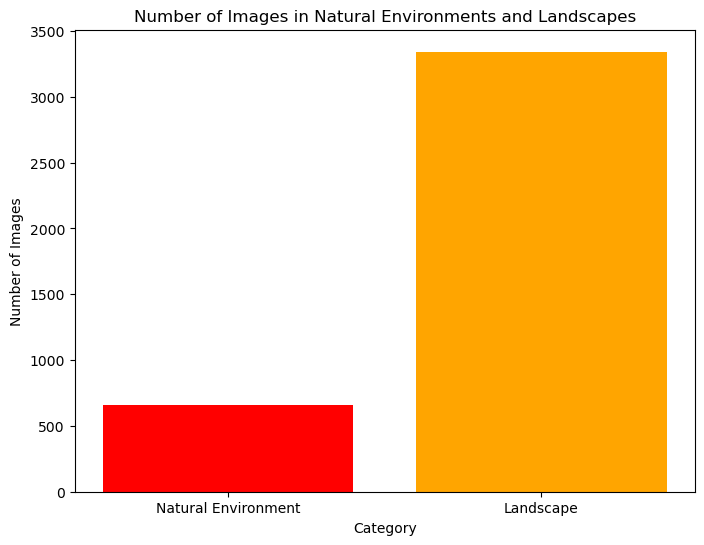

In [5]:
import matplotlib.pyplot as plt

# Function to count the number of images in each category
def count_images_in_category(image_dict):
    count = sum(len(images) for images in image_dict.values())
    return count

# Get the counts of images in each category
natural_environment_count = count_images_in_category(natural_environment_images)
landscape_count = count_images_in_category(landscape_images)

# Plotting
categories = ['Natural Environment', 'Landscape']
counts = [natural_environment_count, landscape_count]

plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['red', 'orange'])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images in Natural Environments and Landscapes')
plt.show()

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import string

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ImageDataset(Dataset):
    def __init__(self, image_folder, captions_file, transform=None):
        self.image_folder = image_folder
        self.captions_file = captions_file
        self.transform = transform
        self.images, self.captions = self.load_data()
        
    def load_data(self):
        with open(self.captions_file, "r") as file:
            captions = file.readlines()

        images = []
        captions_list = []

        for line in captions:
            img_name, caption = line.strip().split("\t")
            images.append(os.path.join(self.image_folder, img_name))
            caption = caption.lower().translate(str.maketrans('', '', string.punctuation)) # Remove punctuations
            captions_list.append(caption)

        return images, captions_list

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        caption = self.captions[idx]

        return image, caption

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

class CNNModel(nn.Module):
    def __init__(self, output_size):
        super(CNNModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, output_size)

    def forward(self, x):
        return self.resnet(x)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embedding(captions)
        inputs = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.lstm(inputs)
        outputs = self.fc(hiddens)
        return outputs

def train_model(image_folder, captions_file, cnn_output_size, lstm_input_size, lstm_hidden_size, vocab_size, num_epochs=10, batch_size=64):
    dataset = ImageDataset(image_folder, captions_file, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    cnn_model = CNNModel(cnn_output_size).to(device)
    lstm_model = LSTMModel(lstm_input_size, lstm_hidden_size, vocab_size).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        for images, captions in dataloader:
            images = images.to(device)
            captions = captions.to(device)

            optimizer.zero_grad()

            features = cnn_model(images)
            outputs = lstm_model(features, captions)

            loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Example usage
train_model(image_folder="/Users/mallikagupta/Desktop/Spring 2024 Courses/STAT 4744/Final Project/Images", captions_file="descriptions.txt", 
            cnn_output_size=512, lstm_input_size=512, lstm_hidden_size=512, vocab_size=10000, 
            num_epochs=5, batch_size=64)

ValueError: not enough values to unpack (expected 2, got 1)